
Today I wanted to have a look at the first Hi-C paper.
Hi-C was a technology that was published while I was studying and always fascinated me. 
Through the power of linking DNA to proteins, a bit of digestion or fragmentation, ligation and sequencing, we can figure out the loops, twists and interactions on a whole genome level. 

If you have not yet heard of Hi-C, you might want to check out the Wikipedia page real quick: [https://en.wikipedia.org/wiki/Hi-C_(genomic_analysis_technique)](https://en.wikipedia.org/wiki/Hi-C_(genomic_analysis_technique)).

In brief: 

Hi-C is a chromosome conformation capture technique that maps spatial interactions between genomic loci by cross-linking, digesting, and ligating DNA fragments, followed by sequencing to analyze contact frequencies, revealing insights into genome organization and chromatin structure dynamics.


## The Paper

The paper describing Hi-C for the first time is Lieberman-Aiden et al. (2009):

"Comprehensive mapping of long range interactions reveals folding principles of the human genome" 

You can read the paper here: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2858594/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2858594/)

I am aiming to reproduce Figure 1 B, the HindIII contact heatmap of the long arm of chromosome 14.
This figure shows the interactions that the method captured but does not yet do much analysis. As such it's a nice way to show how the raw sequencing data is transformed into a format that can then be interpreted. The actual analysis work would come after, where contacts and interactions need to be identified and quantified, but that part I am leaving for another day.

## Getting Set Up

First things first, let's find the data and setup a python environment. 
I am using mamba for this, but you can choose any way to organize your code. 

Luckily the data was deposited for later use, so we can find it on ENA under accession number [PRJNA119555](https://www.ebi.ac.uk/ena/browser/view/PRJNA119555). 

For now let's have a look at the method section of the paper to get some clues how the data was processed.

The authors created a Hi-C library and then aligned it against the human reference genome. 
They then divided the reference into 1 Mb sections and counted links between the regions. 
While they use the hg18 reference genome, we will be using GRCh38. p14. And instead of the Maq aligner I will be using Minimap2 or BWA.

I actively decide against using a Hi-C analysis software, as I want to understand the role of the tools, which means I need to do as much "by hand" as possible. Of course that does not mean that I will be implementing my own aligner, as that would be going a bit too far for now.

A mamba environment is quickly created, I am adding some tools I need later here, so I am all setup for the rest of the analysis.

```sh
mamba create -n reproduce_hic python==3.11 uv==0.3.3 bwa minimap2 samtools
mamba activate reproduce_hic
uv pip install plotnine==0.13.6 pandas==2.2.2 pysam==0.22.1 scipy==1.14.1 numpy==1.25.2 biopython==1.82
```


### Getting the Data

The authors write that the plot 1B was produced using the cell line GM and the restriction enzyme HindIII. The NGS dataset is said to have 8.4 million reads and 6.7 valid interactions. Unfortunately they do not write down which sample id corresponds to that. 

On the ENA portal one can add the read-count and the experiment title as a column. In total there are three sequencing datasets for GM with HindIII. The closest dataset to that stated number, restriction enzyme and cell line has 8.6 million reads with the accession **SRR027959**. While this is not exactly the expected 8.4 million reads, it is likely that this is the dataset that was used.
This experience shows that documenting correctly is key to increase reproducibility, as I already need to start guessing.


To get the data I use curl, but one can also download the data manually from the ENA webpage.

```sh
# Let's make a data folder for us.
mkdir -p data/01/fastq

curl -o data/01/fastq/SRR027959_1.fastq.gz ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR027/SRR027959/SRR027959_1.fastq.gz
curl -o data/01/fastq/SRR027959_2.fastq.gz ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR027/SRR027959/SRR027959_2.fastq.gz
```

For the human reference genome, I use ENSEMBLE as my one stop solution for all my hg38 needs, but of course any provider or database would do.

```sh
curl -o data/hg38.fasta.gz  https://ftp.ensembl.org/pub/release-112/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.toplevel.fa.gz
```

Now I will have a look at the quality of the reads. What was the quality like in 2009?

In [ ]:
%%bash
# fastqc output folder
mkdir -p data/01/fastqc
# fastqc
fastqc data/01/fastq/*.fastq.gz -o data/01/fastqc
# multiqc to get a nice plot quickly
multiqc -p data/01/fastqc -o data/01/fastqc

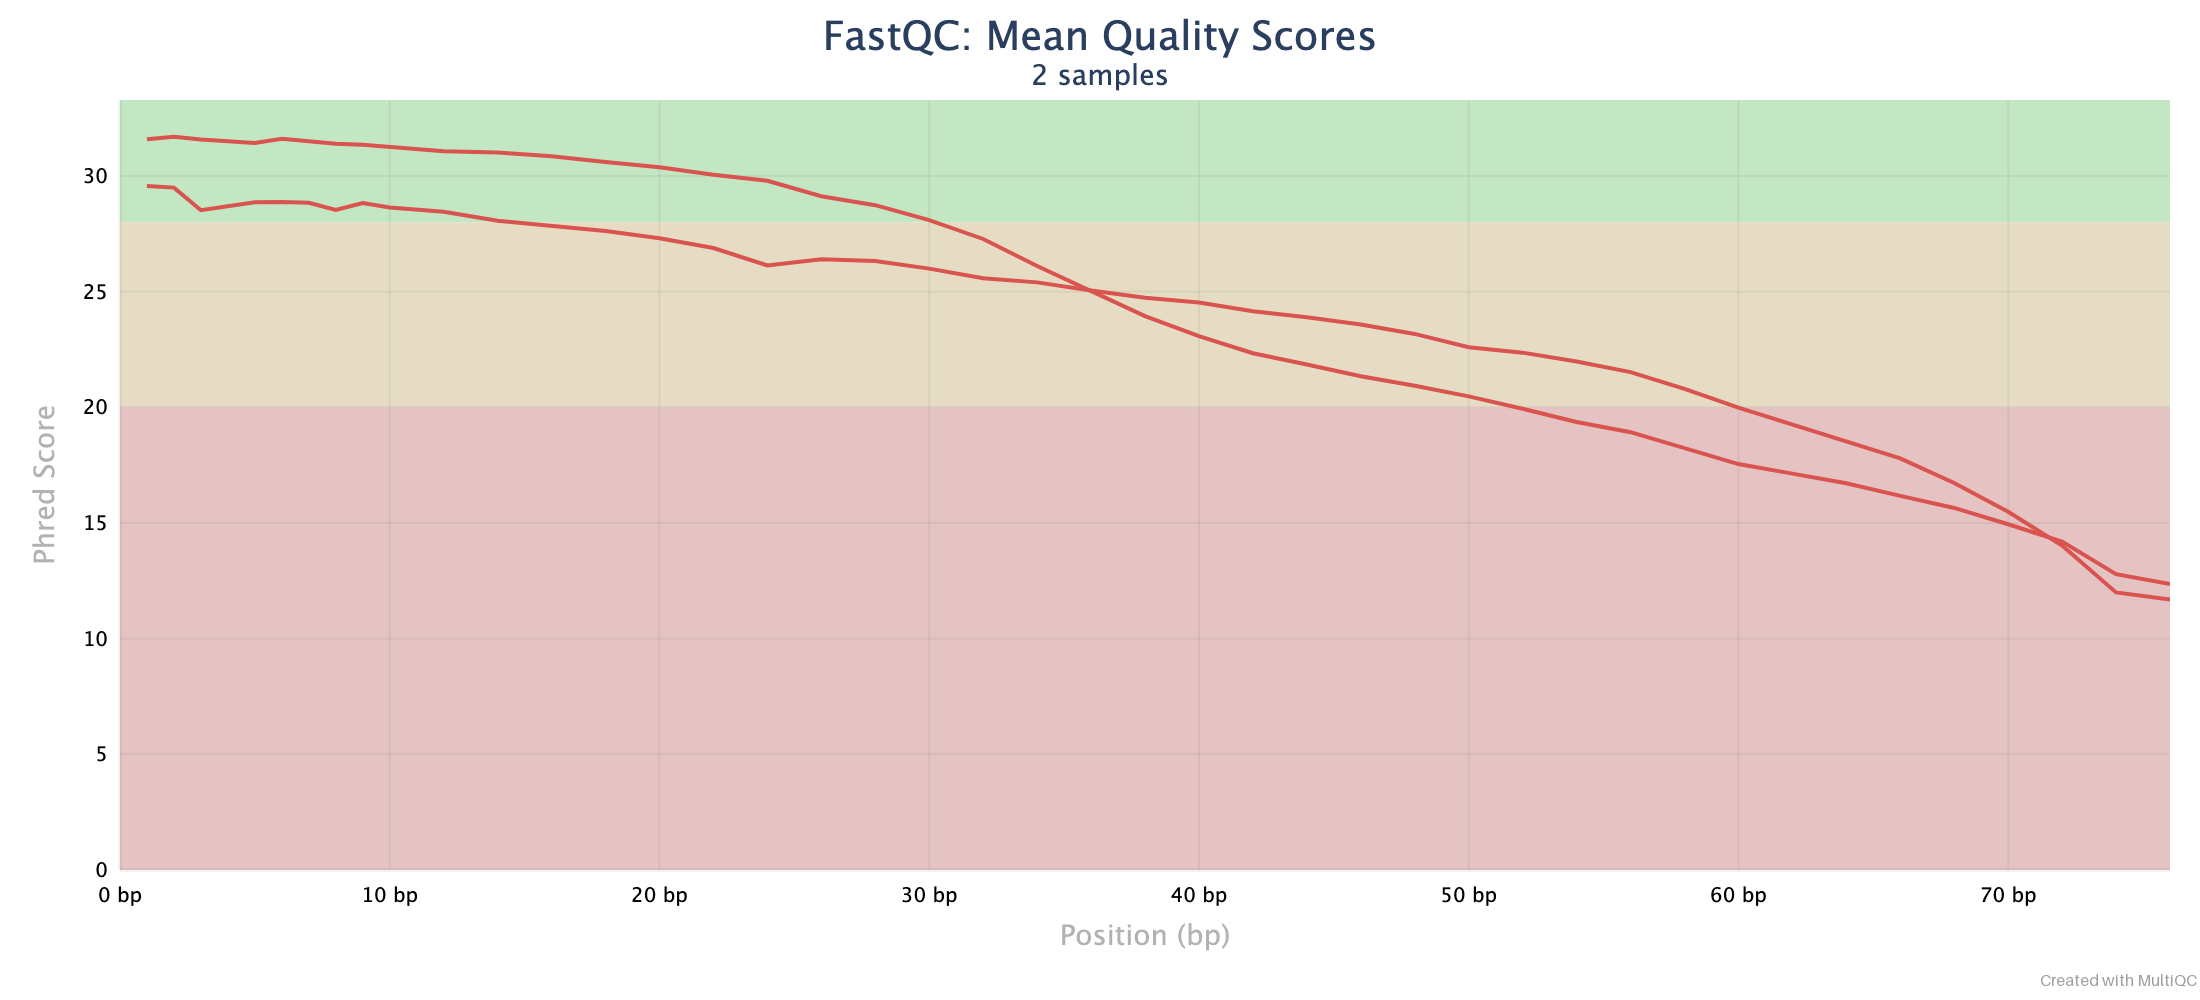

Compared to modern Illumina sequencing datasets the reads are very short and the quality is going down rather quickly. Trimming might end in reads too short to work with and as I don't want to assemble a reference genome here and am only interested in where the reads aligns, working with this data directly should be fine.

## Making Alignments
To align the reads, one first needs to index the reference genome.
I make an index for BWA and for Minimap2, so I can use both of them later when needed.

Notice that for Minimap2, I am ensuring the index to be created for short reads, as Minimap2 by default focuses on long reads (`-ax sr`).

In [ ]:
%%bash
bwa index data/hg38.fasta.gz
minimap2 -ax sr -d data/hg38_sr.mmi data/hg38.fasta.gz

Now that's that done, I can align the reads to the reference genome. 
Importantly most aligners assume that paired-reads map in close proximity. AFAIK, this fact is used by at least BWA and Minimap2 to improve speed and accuracy. In our case the read pairs are separated by long distances, maybe even chromosomes.

To account for this, I see two options: Align each read individually and pair them myself later or use a setting that allows us to have such large inserts. `bwa -5SP` seems to be the setting in this case ([https://phasegenomics.github.io/2019/09/19/hic-alignment-and-qc.html](https://phasegenomics.github.io/2019/09/19/hic-alignment-and-qc.html)). 

I will align the data using those two approaches and in addition I will be using Minimap2's default to see if that makes a difference at all.

### Alignment using BWA and Custom Settings

For BWA I use as many threads as I can get my hands on, in my case that's 12. I am also using the flags `-5SP`. 
The `SP` flag will skip any mate rescue, as far as I understand this means that it will not try to move the paired-read 
to a sensibly close location to the first read. And the `-5` flag, also called the Hi-C flag, is a setting for `split alignment`.

For Samtools I use the filter `-F 2304`, meaning it will remove all unmapped reads and secondary alignments. 
If you are new to Samtools flags, this page can help decoding the flags: [https://broadinstitute.github.io/picard/explain-flags.html](https://broadinstitute.github.io/picard/explain-flags.html).

In [ ]:
%%bash
THREADS=12
bwa mem -t ${THREADS} -5SP \
    data/hg38.fasta.gz data/01/fastq/{SRR027959_1.fastq.gz,SRR027959_2.fastq.gz} |\
    samtools view -S -h -F 2304 -b - |\
    samtools sort -n -@  ${THREADS} -o data/01/split_aligned.bam

### Alignment of Reads Separately

For this approach I simply treat both the forward and the reverse read as separate datasets. To avoid Minimap2 automatically recovering any connection between the two, I am performing two separate alignments. This way I am sure the aligner does what I think it does. 

Once both are aligned, I merge the bam files to obtain one clean alignment file.

In [ ]:
%%bash
THREADS=12

# Align the first read file
minimap2 -ax sr -t ${THREADS} data/hg38.fasta.gz data/01/fastq/SRR027959_1.fastq.gz |\
    samtools view -S -h -F 2304 -b  - > data/01/aligned_SR27_1.bam

# Align the second read file
minimap2 -ax sr -t ${THREADS} data/hg38.fasta.gz data/01/fastq/SRR027959_2.fastq.gz |\
    samtools view -S -h -F 2304 -b  - > data/01/aligned_SR27_2.bam

# Merge the two BAM files
samtools merge -@ ${THREADS} data/01/merged_aligned.bam data/01/aligned_SR27_1.bam data/01/aligned_SR27_2.bam

# Sort the merged BAM file by read name
samtools sort -n -@ ${THREADS} -o data/01/separately_aligned.bam data/01/merged_aligned.bam

# Clean up intermediate files if desired
rm data/01/aligned_SR27_1.bam data/01/aligned_SR27_2.bam data/01/merged_aligned.bam

### Alignment with Minimap2 Defaults

As a control, I also want to align using Minimap2's defaults for short reads. I also remove secondary alignments and unmapped reads, but besides this, it's very vanilla.

In [ ]:
%%bash
THREADS=12
minimap2 -ax sr -t ${THREADS} data/hg38.fasta.gz \
    data/01/fastq/{SRR027959_1.fastq.gz,SRR027959_2.fastq.gz} |\
    samtools view -S -h -F 2304 -b - |\
    samtools sort -n -@  ${THREADS} -o data/01/minimap2_aligned.bam

## Processing Bam Files

Now that the data is aligned I need to create a link matrix to make a nice heatmap.
Thanks to some awesome python libraries one can do this very easily in python.

I first need to know how big our chromosomes are, as for Figure 1B I need to make bins of 1 Mb size along the entire chromosome. 

I am using Biopython for that:

In [47]:
import gzip
from Bio import SeqIO

# Open the FASTA file and create the genome file
with open("data/hg38.txt", "w") as genome_file, gzip.open("data/hg38.fasta.gz", "rt") as fasta_file:
    for record in SeqIO.parse(fasta_file, "fasta"):
        genome_file.write(f"{record.id}\t{len(record.seq)}\n")

In [48]:
 %%bash
 head -n 4 data/hg38.txt

1	248956422
2	242193529
3	198295559
4	190214555


Now that I have a hg38.txt, describing the chromosome size, it's relatively easy to get the count matrix. 

The next bit of code deals with processing the bam file and finding paired reads. 
In short: This function enables me to go through a name sorted (`-n`) bamfile and resolve read pairs by their matching name. It only returns pairs where both partners are aligned. I left a few comments, have a look through the code, it should be pretty self explanatory.

In [25]:
import os
import pysam
from functools import partial
import numpy as np
from tqdm import tqdm
from scipy.sparse import lil_matrix
import pysam
from tqdm import tqdm
from typing import Generator, Dict

def linked_reads(bam_file: str) -> Generator[Dict[str, str | int], None, None]:
    """
    Generator function to yield linked read information from a BAM file.

    Args:
        bam_file (str): Path to the BAM file.

    Yields:
        Generator[Dict[str, str | int]]: A dictionary containing information about linked reads.
    """
    # Open the BAM file for reading
    bamfile = pysam.AlignmentFile(bam_file, "rb")
    previous_read = None

    # Iterate over each read in the BAM file with a progress bar
    for read in tqdm(bamfile, desc="Processing reads", unit=" reads"):
        
        # Check if there is a previous read to compare with
        if previous_read:                
            # Check if the current read is a mate of the previous read
            # We use the name for this
            if previous_read.query_name == read.query_name:
                # Only return if both reads are aligned
                if previous_read.reference_start > 0 and read.reference_start > 0:
                   # Yield a dictionary with information about the linked reads
                    yield {
                        "name": previous_read.query_name,
                        "chromosome": previous_read.reference_name,
                        "position": previous_read.reference_start,
                        "mate_name": read.query_name,
                        "mate_chromosome": read.reference_name,
                        "mate_position": read.reference_start
                    }
                previous_read = None # Read was consumed
                continue
                    
        # Update the previous_read to the current read for the next iteration
        previous_read = read

    # Close the BAM file after processing
    bamfile.close()

To see how well my alignments worked, I can use this function to count how many read pairs we have for each of our aligned bam files. As a reference, I also added the raw read count, so I can see what fraction of reads made proper read-pairs.

Processing reads: 17388147 reads [00:18, 927626.21 reads/s] 
Processing reads: 17214886 reads [00:21, 790876.72 reads/s]
Processing reads: 17214886 reads [00:20, 823557.01 reads/s]


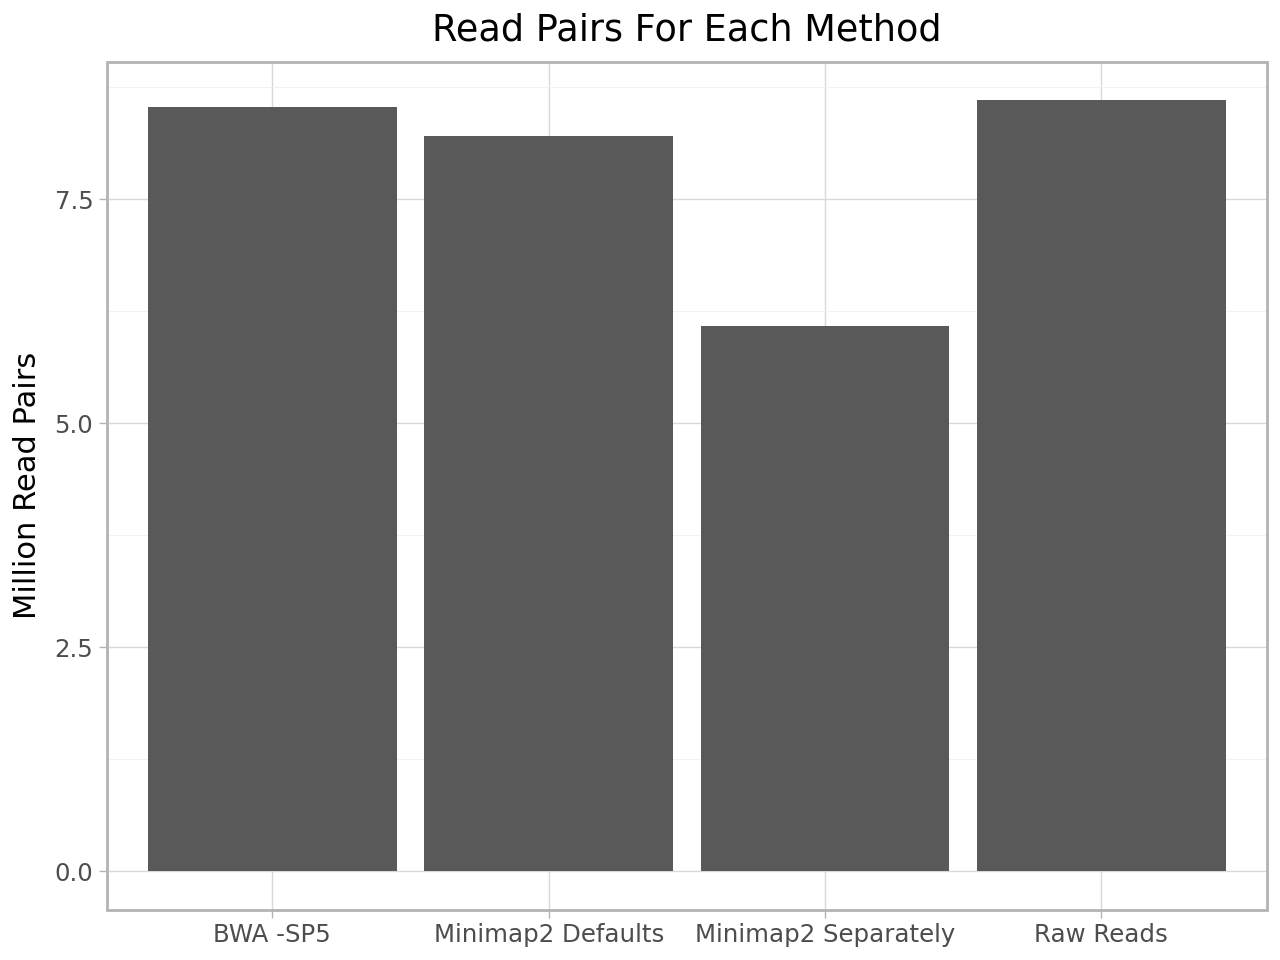

In [56]:
import plotnine as p9
import pandas as pd
from glob import glob
import subprocess

# I count the number of rows in one file, and divide by 4
# Assuming that all reads have pairs
fastq_file = "data/01/fastq/SRR027959_1.fastq.gz"
read_count = int(subprocess.run(f"zcat {fastq_file} | wc -l", shell=True, capture_output=True, text=True).stdout) / 4

alignment_files = glob("data/01/*aligned.bam")

# Loop trough all bam files and count the linked reads
aligned_pairs = {}
for path in alignment_files:
    aligned_pairs[os.path.basename(path)] = sum([1 for _ in linked_reads(path)])

aligned_pairs[os.path.basename(fastq_file)] = read_count

# To make the plot nicer, I made this simple mapping
name_mapping = {
    "minimap2_aligned.bam": "Minimap2 Defaults",
    "separately_aligned.bam" : "Minimap2 Separately",
    "split_aligned.bam" : "BWA -SP5",
    "SRR027959_1.fastq.gz": "Raw Reads"
}

# Create a pandas DataFrame for easy plotting
df = pd.DataFrame(list(aligned_pairs.items()), columns=['File', 'Count'])
df["Name"] = df["File"].map(lambda x: name_mapping.get(x, x))
df['Fraction'] = df['Count'] / df.loc[df['Name'] == 'Raw Reads', 'Count'].values[0]

(p9.ggplot(df, p9.aes(x="Name", y="Count/1e6")) +
    p9.geom_col() + 
    p9.theme_light()  +
    p9.labs(title=f"Read pairs for each method".title(), 
            y = "Million Read pairs".title(),
            x = ""
            )
)

Firstly it is nice to see that the bam parsing function is performing fast enough, on my machine I get 800k reads/s, which I think is a reasonable speed.

To no one's surprise, BWA with the Hi-C specific settings yields most read pairs (8.5 Million), but surprisingly Minimap2 with default settings is not far behind. The worst seems to be to align reads separately (only 70% reads recovered), which is a bit unexpected and I would love to hear ideas why that is. 

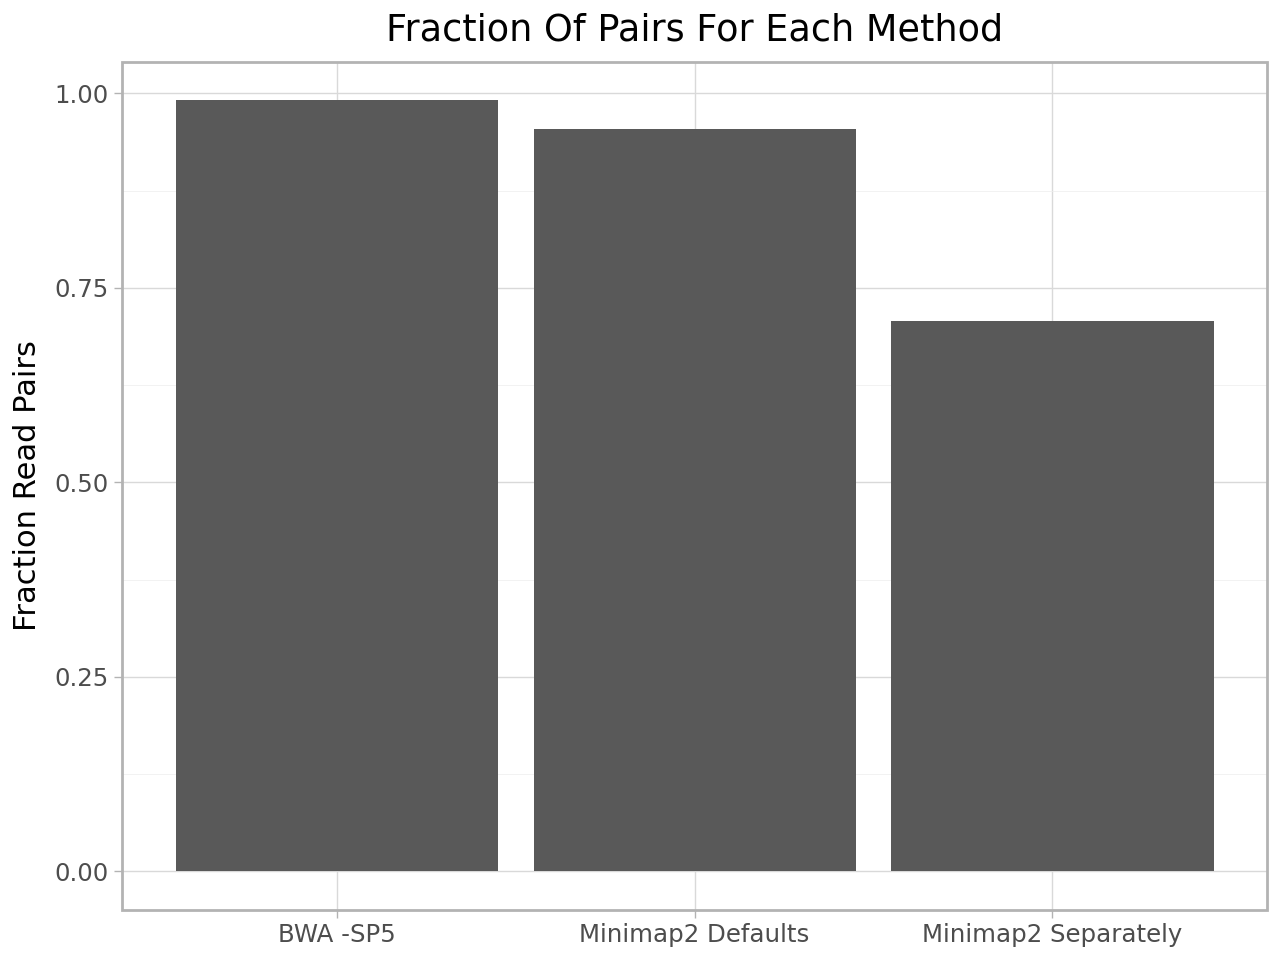

In [55]:
(p9.ggplot(df[df["Name"] != "Raw Reads"], p9.aes(x="Name", y="Fraction")) +
      p9.geom_col() + 
      p9.theme_light()  +
      p9.labs(title=f"Fraction of pairs for each method".title(), 
              y = "Fraction Read pairs".title(),
              x = ""
              )
)

Looking at the fraction of reads I get aligned, the results are very encouraging, with BWA aligning over 99% and Minimap2 aligning 95% of all possible pairs.

In [5]:
def get_chromosome_definition(file: str):
    """
    Simple function to read the chromosome sizes
    """
    allowed_chromosomes = [str(x) for x in range(1, 23)] + ["X", "Y"]
    
    if not os.path.exists(file):
        raise FileNotFoundError(f"File {file} not found")
    
    chromosomes = {}
    with open(file, "r") as f:
        for line in f:
            chromosome, length = line.strip().split("\t")
            # For now we skip non 1-22, X, Y chromosomes
            if chromosome not in allowed_chromosomes:
                continue
            chromosomes[chromosome] = int(length)
    return chromosomes


def position2index(position: int, windowsize: int) -> int:
    """
    Within a chromosome we can determine the bin index
    by simply dviding by the window size. Easy and fast.
    """
    return position // windowsize


def chromosome2index(chromosomes: dict[str, int], 
                     index_fn: callable):
    """
    Each chromosome has an offset to the beginning, 
    we can store that index and make our life easy.
    """
    chrs = sorted(chromosomes.keys())
    running_sum = 0
    index = {}
    for chr in chrs:
        index[chr] = index_fn(running_sum)
        running_sum += chromosomes[chr]
    return index


def get_index(chromosome: int, 
              position: int, 
              chromosome_offset: dict[str, int],
              index_fn: callable
              ) -> int:
    """
    A convienience function to get the window index of a read
    once we have defined all the offsets.
    """
    return int(index_fn(position)) + int(chromosome_offset[chromosome])



def get_hic_matrix(bam_file: str, 
                   genome_txt: str, 
                   window_size: int) -> np.ndarray:
    """
    This is the main function that creates the Hi-C matrix.
    I will add a few comments.    
    """

    # Setup the matrix indexing.
    # Given a window size and the total sum of all chromosomes
    # We know that m = genome size // window length
    # These functions let us access this logic quickly
    chromosomes = get_chromosome_definition(genome_txt)
    internal_index = partial(position2index, windowsize = window_size)
    chromosome_offset = chromosome2index(chromosomes, index_fn = internal_index)

    get_index_fn = partial(get_index, 
                        chromosome_offset = chromosome_offset,
                        index_fn = internal_index)
    
    # The matrix is shape mxm
    possible_windows = sum([internal_index(length) for length in chromosomes.values()])
    m = len(chromosomes) * int(possible_windows)
    
    # We make a sparse matrix, so we dont use to much RAM
    hic_matrix = lil_matrix((m,m))
    
    for result in linked_reads(bam_file):
        try:
            index1 = get_index_fn(position=result["position"], chromosome=result["chromosome"])
            index2 = get_index_fn(position=result["mate_position"], chromosome=result["mate_chromosome"])
            
            # increment matrix 
            hic_matrix[index1, index2] = hic_matrix[index1, index2] + 1
            # As its symmetric, we need to increment here too
            hic_matrix[index2, index1] = hic_matrix[index2, index1] + 1
        except KeyError:
            # we skip non 1-22, X, Y chromosomes
            pass
        
    return hic_matrix, get_index_fn

Now that all the heavy lifting is done, I can simply pass a bam file to the `get_hic_matrix` function and get a Hi-C matrix. 
As I am only interested in chromosome 14, I could filter that bam file first, but the overhead is bearable, so I stick with the full bam file for now. After creating the matrix I am reducing it to the long arm of chromosome 14 to save some memory.

In [6]:
import plotnine as p9
import pandas as pd
from glob import glob
import numpy as np

def plotting_data(matrix: np.array, 
                  chromosome: str, 
                  start: int, 
                  end: int,
                  index_fn: callable) -> pd.DataFrame:
    start_index = index_fn(chromosome, start)
    end_index  = index_fn(chromosome, end)
    M = matrix.tocsr()[start_index:end_index, start_index:end_index].toarray()
    M = np.fliplr(M)
    
    df = pd.DataFrame(M, columns=[f"col_{i:010}" for i in range(M.shape[1])])
    df['x'] = df.columns
    
    dfm = df.melt(id_vars='x', var_name='y', value_name='count')
    
    return dfm

bam_files = glob("data/01/*aligned.bam")

genome_txt = "data/hg38.txt"
window_size = 1e6 # 1 Mb
chrom = "14"
chromosomes = get_chromosome_definition(genome_txt)

matrices = {}

for bam_file in bam_files:
    hic_matrix, hic_index_fn = get_hic_matrix(bam_file, genome_txt, window_size)     
    matrices[os.path.basename(bam_file)] = plotting_data(hic_matrix, 
                        chromosome=chrom, 
                        start=18e6, # ignore light arm of chr14
                        end=chromosomes[chrom], 
                        index_fn=hic_index_fn)
    


Processing reads: 17388147 reads [00:59, 292585.21 reads/s]
Processing reads: 17214886 reads [01:17, 221198.85 reads/s]
Processing reads: 17214886 reads [01:11, 239118.84 reads/s]


Now I have a nice subsetted matrix to make beautiful plots. Let's first make a nice plotting function. 

In [7]:
def plot_hic(df):
    p = (p9.ggplot(df, p9.aes(x="x", y="y", fill="count")) +
        p9.geom_tile() +
        p9.scale_fill_gradient(low="white", high="darkred", name="# Links") +
        p9.theme_light() +
        p9.theme(
            axis_text_x=p9.element_blank(),
            axis_text_y=p9.element_blank(),
            axis_ticks=p9.element_blank(),
            axis_title_x=p9.element_blank(),
            axis_title_y=p9.element_blank()
        ) +
        p9.coord_fixed() +
        p9.labs(title=f"Chromosome {chrom}")
    )
    return p

Let's make our first plot:

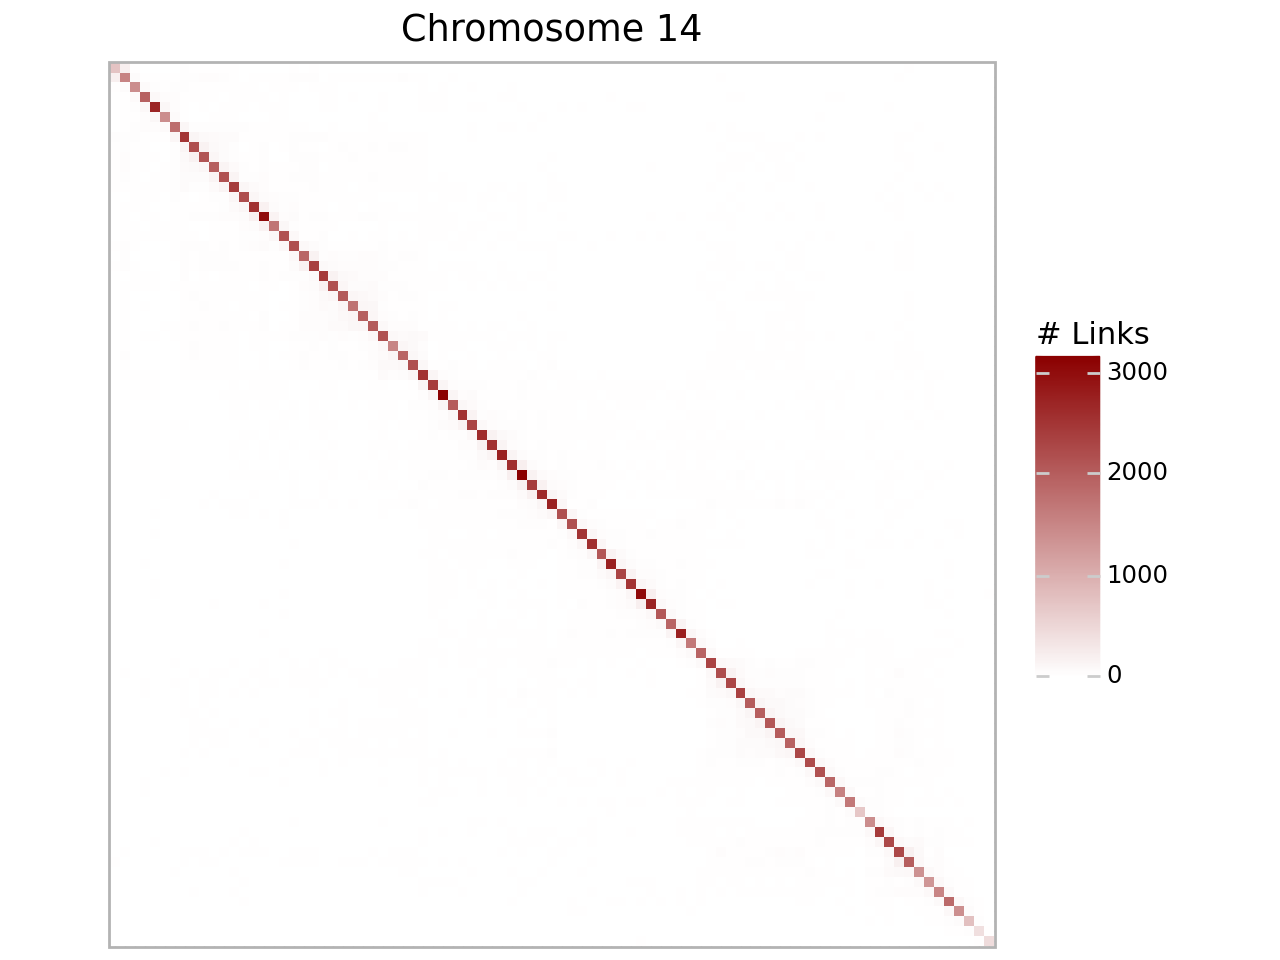

In [8]:
plot_hic(matrices["split_aligned.bam"])

What is that? Well, I do see the diagonal, but aren't I supposed to see all kinds of cis-interactions?

I expected this to happen, Hi-C data is not perfect. In fact most contacts in Hi-C datasets are very close range interactions. How many? Let's take a quick look and plot the genomic distance for cis-links of chromosome 14:

In [9]:
links = []
for link in linked_reads("data/01/split_aligned.bam"):
    if link["chromosome"] != link["mate_chromosome"]:
        continue
    links.append({"Chromosome": link["chromosome"], 
                  "distance": abs(link["position"] - link["mate_position"])
                  })
links = pd.DataFrame(links)

Processing reads: 17214886 reads [00:22, 759021.30 reads/s]


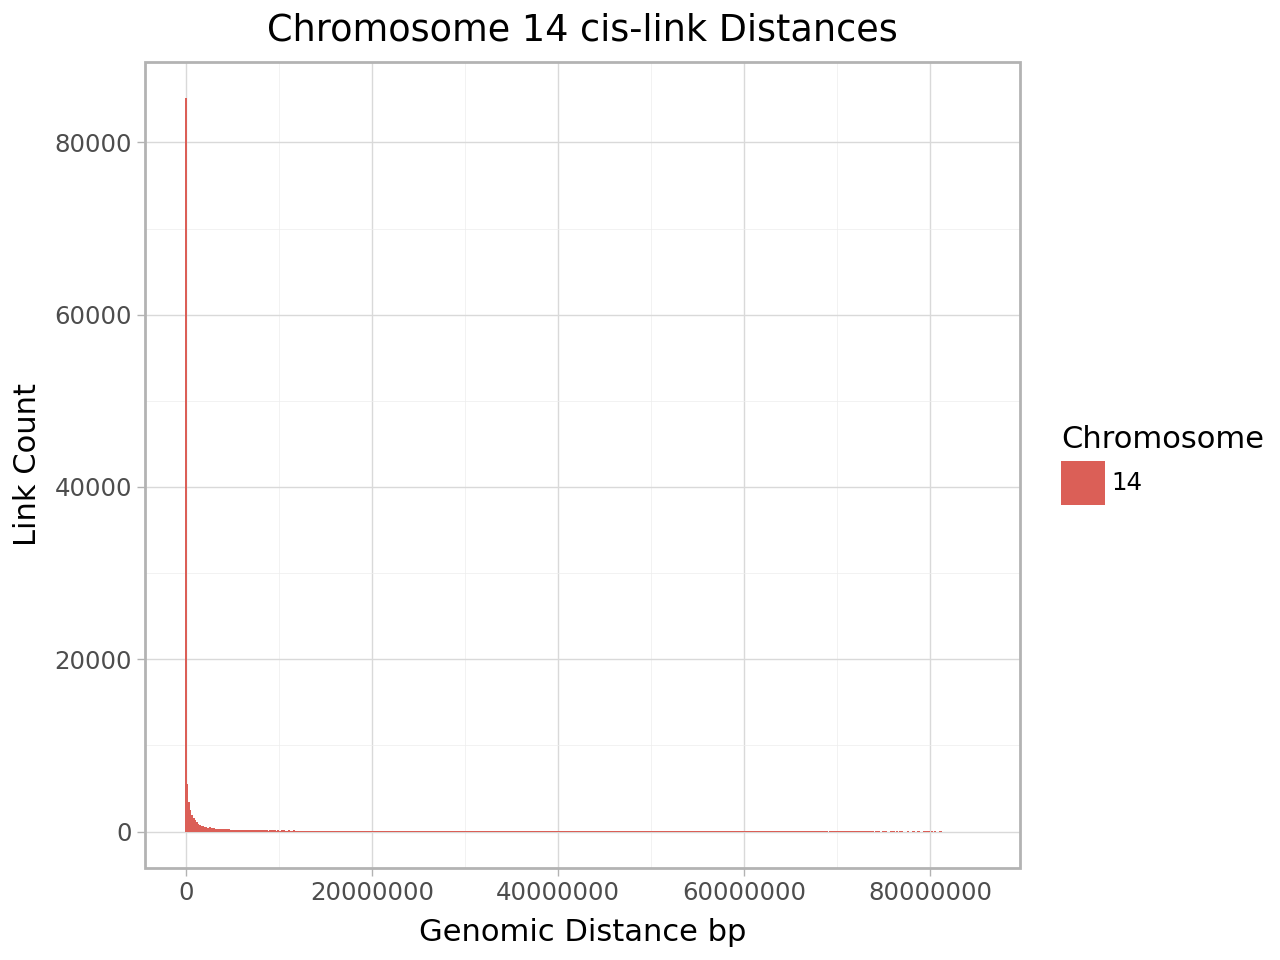

In [57]:
(p9.ggplot(links[links["Chromosome"] == "14"], p9.aes("distance", fill="Chromosome")) +
    p9.geom_histogram(bins=500) + 
    p9.theme_light() +
    p9.labs(title=f"Chromosome {chrom} cis-link Distances", y = "Link Count", x="Genomic Distance bp")
)

Clearly most interactions are very close range. One can log scale the y-axis to see more interactions. 

/home/paul/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/home/paul/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10


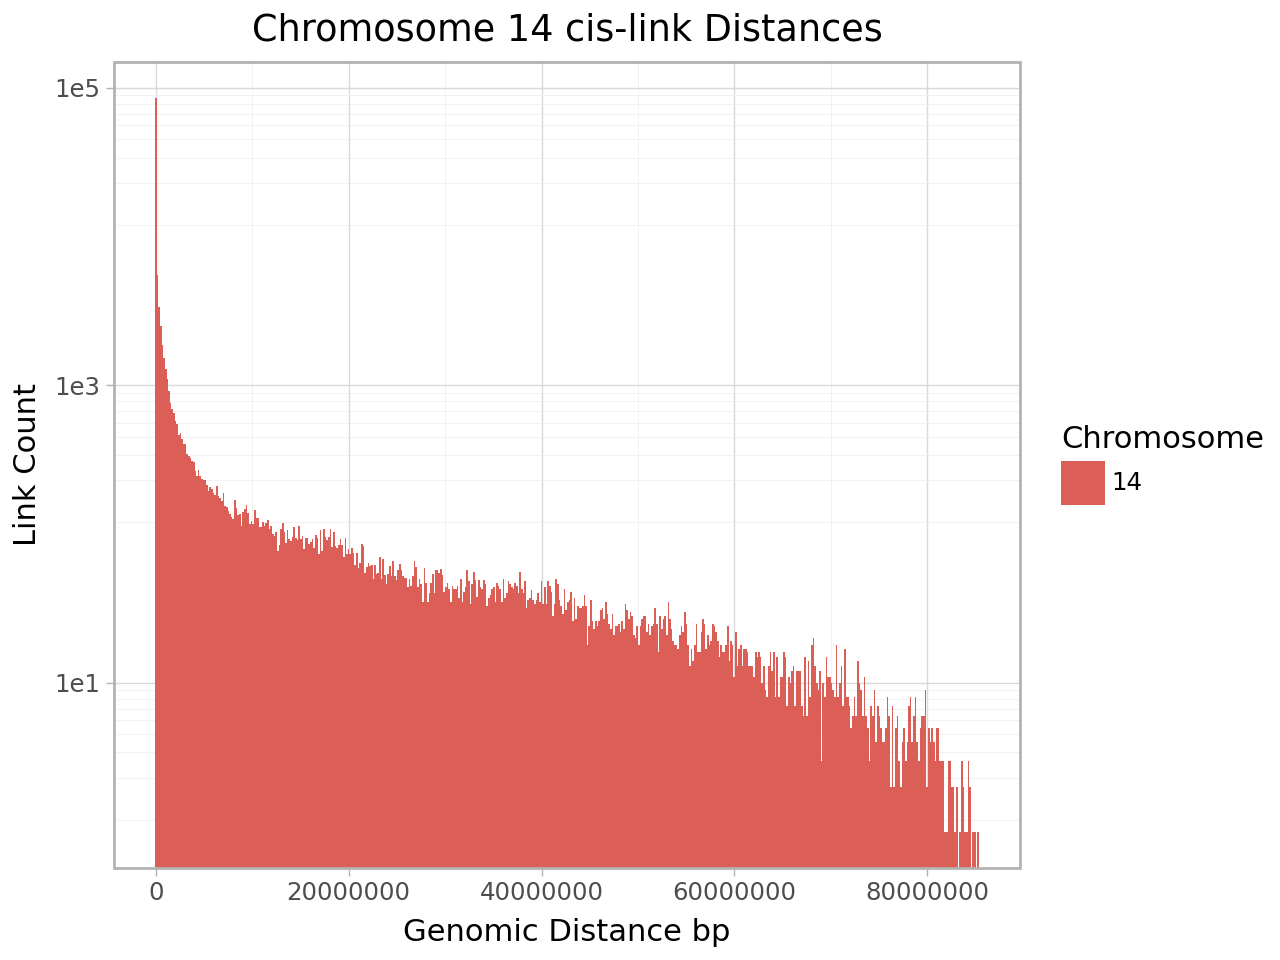

In [58]:
(p9.ggplot(links[links["Chromosome"] == "14"], p9.aes("distance", fill="Chromosome")) +
    p9.geom_histogram(bins=500) + 
    p9.scale_y_log10() +
    p9.theme_light() +
    p9.labs(title=f"Chromosome {chrom} cis-link Distances", y = "Link Count", x="Genomic Distance bp")
)

In the original paper they mention, that they set the limit to 0-50 for their heatmap. So let's try that by setting limits using `limits=(0, n)` with n set to 50. 

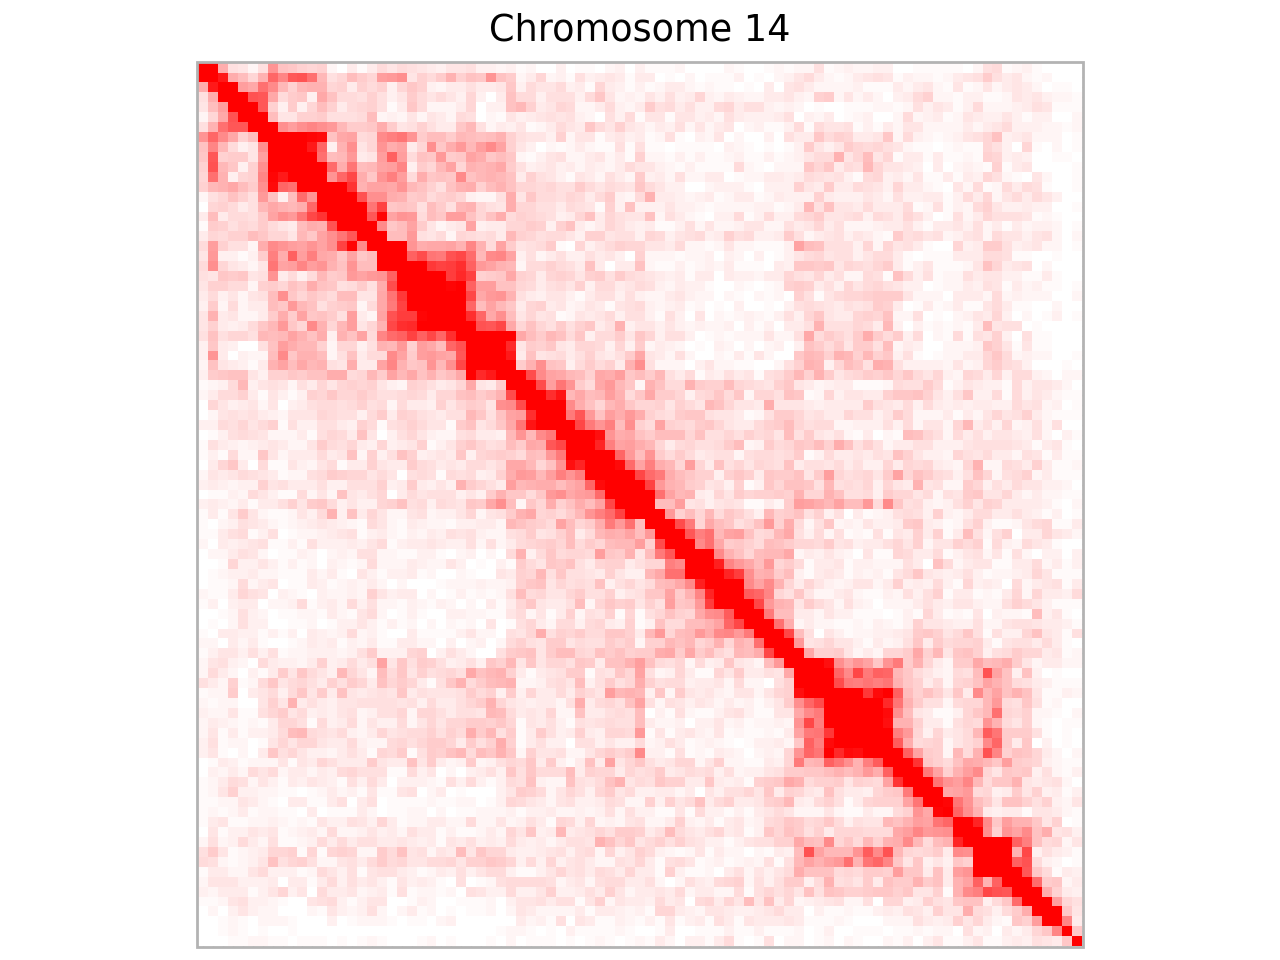

In [24]:
def plot_hic_limit(df, n: int = 50, chrom: str = "14"):
    p = (p9.ggplot(df, p9.aes(x="x", y="y", fill="count")) +
        p9.geom_tile(show_legend=False) +
        p9.scale_fill_gradient(low="white", high="red", name="# Links", limits=(0, n)) +
        p9.theme_light() +
        p9.theme(
            axis_text_x=p9.element_blank(),
            axis_text_y=p9.element_blank(),
            axis_ticks=p9.element_blank(),
            axis_title_x=p9.element_blank(),
            axis_title_y=p9.element_blank(),
        ) +
        p9.coord_fixed() +
        p9.labs(title=f"Chromosome {chrom}")
    )
    return p


plot_hic_limit(matrices["split_aligned.bam"])


That looks much better, dare I say it looks perfect? Well maybe not perfect, but very close to the original Figure 1B I am trying to reproduce. 

I am now plotting this figure for all three alignment settings:

In [21]:
! mkdir -p data/01/plots/
for name, matrix in matrices.items():
    p = plot_hic_limit(matrix)
    p9.ggsave(p, filename = f"data/01/plots/{name}.png", width = 8, height = 6, verbose = False)

I use Matplotlib to make a grid using the PNGs to compare to the original paper. 

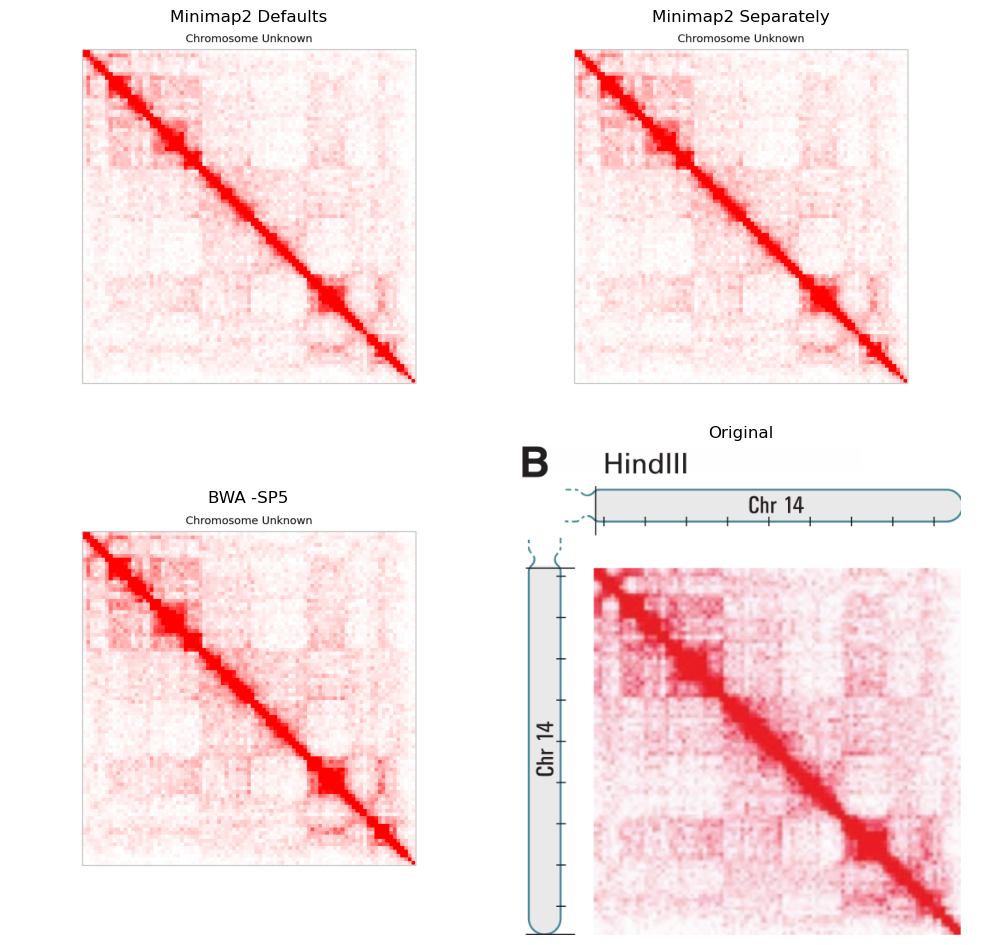

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_in_grid(image_paths, titles):
    """
    Plots four images in a 2x2 grid with corresponding titles.

    Parameters:
    image_paths (list): A list of four paths to PNG images.
    titles (list): A list of four titles for the images.
    """
    if len(image_paths) != 4 or len(titles) != 4:
        raise ValueError("Both image_paths and titles must contain exactly four elements.")

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path, title in zip(axs.flatten(), image_paths, titles):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()


plot_images_in_grid(["data/01/plots/minimap2_aligned.bam.png",
                     "data/01/plots/separately_aligned.bam.png",
                     "data/01/plots/split_aligned.bam.png",
                     "data/01/original_fig1b.png"],
                    [name_mapping["minimap2_aligned.bam"],
                     name_mapping["separately_aligned.bam"],
                     name_mapping["split_aligned.bam"],
                     'Original'])


Comparing my figures to the original (lower right, by Lieberman-Aiden et al. (2009)), I would say I have successfully recreated the Figure 1B. Many features that are hallmarks of the original can be found in my reproductions. Even the differences between the alignment methods are minimal, it's like spot the difference and there are not many. 

One noticeable difference between my reproduction and the original is the strength of some of the hot-spots (compare the cross pattern in the upper left corner).
They are  weaker in my reproduction, this might be an artifact from the very high compression of the original image or point to some differences in the implementation. 

Overall I am happy with the results. 


Until next time.